# Cleaning US Census Data

You just got hired as a Data Analyst at the Census Bureau, which collects census data and creates interesting visualizations and insights from it.

The person who had your job before you left you all the data they had for the most recent census. It is in multiple `csv` files. They didn't use pandas, they would just look through these `csv` files manually whenever they wanted to find something. Sometimes they would copy and paste certain numbers into Excel to make charts.

The thought of it makes you shiver. This is not scalable or repeatable.

Your boss wants you to make some scatterplots and histograms by the end of the day. Can you get this data into `pandas` and into reasonable shape so that you can make these histograms?

## Inspect the Data!

1. The first visualization your boss wants you to make is a scatterplot that shows average income in a state vs proportion of women in that state.

   Open some of the census `csv` files that came with the kit you downloaded. How are they named? What kind of information do they hold? Will they help us make this graph?

In [1]:
#It does look like they will have the data we need to make the requested scatterplot.

2. It will be easier to inspect this data once we have it in a DataFrame. You can't even call `.head()` on these `csv`s! How are you supposed to read them?

   Using `glob`, loop through the census files available and load them into DataFrames. Then, concatenate all of those DataFrames together into one DataFrame, called something like `us_census`.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

census_files = glob.glob('states[0-9].csv')
df_list = []
for file in census_files:
    df_list.append(pd.read_csv(file))

us_census = pd.concat(df_list)

3. Look at the `.columns` and the `.dtypes` of the `us_census` DataFrame. Are those datatypes going to hinder you as you try to make histograms?

In [3]:
print(us_census.columns, us_census.dtypes)

Index(['Unnamed: 0', 'State', 'TotalPop', 'Hispanic', 'White', 'Black',
       'Native', 'Asian', 'Pacific', 'Income', 'GenderPop'],
      dtype='object') Unnamed: 0     int64
State         object
TotalPop       int64
Hispanic      object
White         object
Black         object
Native        object
Asian         object
Pacific       object
Income        object
GenderPop     object
dtype: object


4. Look at the `head()` of the DataFrame so that you can understand why some of these `dtypes` are objects instead of integers or floats.

   Start to make a plan for how to convert these columns into the right types for manipulation.

In [4]:
us_census.head()

,Unnamed: 0,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop
0,0,Alabama,4830620,3.75%,61.88%,31.25%,0.45%,1.05%,0.03%,"$43,296.36",2341093M_2489527F
1,1,Alaska,733375,5.91%,60.91%,2.85%,16.39%,5.45%,1.06%,"$70,354.74",384160M_349215F
2,2,Arizona,6641928,29.57%,57.12%,3.85%,4.36%,2.88%,0.17%,"$54,207.82",3299088M_3342840F
3,3,Arkansas,2958208,6.22%,71.14%,18.97%,0.52%,1.14%,0.15%,"$41,935.63",1451913M_1506295F
4,4,California,38421464,37.29%,40.22%,5.68%,0.41%,13.05%,0.35%,"$67,264.78",19087135M_19334329F


## Regex to the Rescue

5. Use regex to turn the `Income` column into a format that is ready for conversion into a numerical type.

In [5]:
us_census.Income = us_census.Income.str.replace('\$', "").str.replace('\,', '')
us_census.Income.head()

C:\Users\moorejd\AppData\Local\Temp\ipykernel_2968\392208145.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  us_census.Income = us_census.Income.str.replace('\$', "").str.replace('\,', '')


0    43296.36 
1    70354.74 
2    54207.82 
3    41935.63 
4    67264.78 
Name: Income, dtype: object

6. Look at the `GenderPop` column. We are going to want to separate this into two columns, the `Men` column, and the `Women` column.

   Split the column into those two new columns using `str.split` and separating out those results.

In [6]:
gender_str= us_census.GenderPop.str.split('_')
us_census['Men'] = gender_str.str.get(0)
us_census['Women'] = gender_str.str.get(1)

7. Convert both of the columns into numerical datatypes.

   There is still an `M` or an `F` character in each entry! We should remove those before we convert.

In [7]:
us_census.Men = us_census.Men.str.replace('M', '')
us_census.Women = us_census.Women.str.replace('F', '')
us_census.Men = pd.to_numeric(us_census.Men)
us_census.Women = pd.to_numeric(us_census.Women)
us_census.Income = pd.to_numeric(us_census.Income)


8. Now you should have the columns you need to make the graph and make sure your boss does not slam a ruler angrily on your desk because you've wasted your whole day cleaning your data with no results to show!

   Use matplotlib to make a scatterplot!
   
   ```py
   plt.scatter(the_women_column, the_income_column)
   ```
   
   Remember to call `plt.show()` to see the graph!

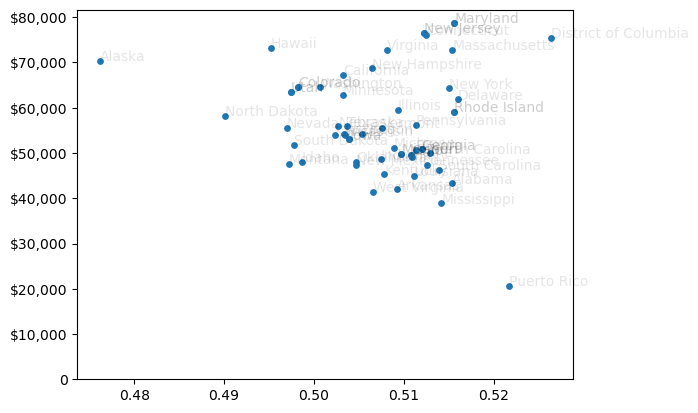

In [8]:
# filling NaNs for Women pop per state:
us_census.Women.fillna(us_census.TotalPop - us_census.Men, inplace = True)
us_census['Women_Prop'] = us_census.Women / (us_census.Men + us_census.Women)

ax = plt.subplot()
plt.scatter('Women_Prop', 'Income', data = us_census, s = 15)
ax.set_yticks(ticks = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], labels = ['0', '$10,000', '$20,000', '$30,000', '$40,000', '$50,000', '$60,000', '$70,000', '$80,000'])
for i, txt in enumerate(us_census.State):
    ax.annotate(txt, (list(us_census.Women_Prop)[i], list(us_census.Income)[i]), alpha = .1, size = 10 )
plt.show()

9. You want to double check your work. You know from experience that these monstrous csv files probably have `nan` values in them! Print out your column with the number of women per state to see.

   We can fill in those `nan`s by using pandas' `.fillna()` function.
   
   You have the `TotalPop` per state, and you have the `Men` per state. As an estimate for the `nan` values in the `Women` column, you could use the `TotalPop` of that state minus the `Men` for that state.
   
   Print out the `Women` column after filling the `nan` values to see if it worked!

10. We forgot to check for duplicates! Use `.duplicated()` on your `census` DataFrame to see if we have duplicate rows in there.

In [9]:
us_census.duplicated(subset = {'State'})

0    False
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
0     True
1    False
2    False
3    False
4    False
5    False
dtype: bool

11. Drop those duplicates using the `.drop_duplicates()` function.

In [10]:
us_census.drop_duplicates(subset = {'State'}, inplace = True)

12. Make the scatterplot again. Now, it should be perfect! Your job is secure, for now.

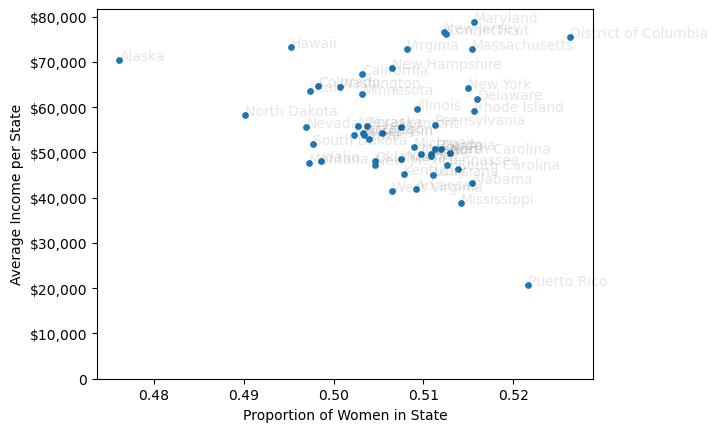

In [11]:
ax = plt.subplot()
plt.scatter('Women_Prop', 'Income', data = us_census, s = 15)
ax.set_yticks(ticks = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000], labels = ['0', '$10,000', '$20,000', '$30,000', '$40,000', '$50,000', '$60,000', '$70,000', '$80,000'])
plt.ylabel('Average Income per State')
plt.xlabel('Proportion of Women in State')
for i, txt in enumerate(us_census.State):
    ax.annotate(txt, (list(us_census.Women_Prop)[i], list(us_census.Income)[i]), alpha = .1, size = 10 )
plt.show()

## Histogram of Races

13. Now your boss wants you to make a bunch of histograms out of the race data that you have. Look at the `.columns` again to see what the race categories are.

In [12]:
races = ['Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific']
for race in races:
    us_census[race] = us_census[race].str.replace('%$', '')
    
for race in races:
    us_census[race] = us_census[race].astype('float64')
    

C:\Users\moorejd\AppData\Local\Temp\ipykernel_2968\2024493458.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  us_census[race] = us_census[race].str.replace('%$', '')


,Unnamed: 0,State,TotalPop,Hispanic,White,Black,Native,Asian,Pacific,Income,GenderPop,Men,Women,Women_Prop
0,0,Alabama,4830620,3.75,61.88,31.25,0.45,1.05,0.03,43296.36,2341093M_2489527F,2341093,2489527.0,0.515364
1,1,Alaska,733375,5.91,60.91,2.85,16.39,5.45,1.06,70354.74,384160M_349215F,384160,349215.0,0.476175
2,2,Arizona,6641928,29.57,57.12,3.85,4.36,2.88,0.17,54207.82,3299088M_3342840F,3299088,3342840.0,0.503294
3,3,Arkansas,2958208,6.22,71.14,18.97,0.52,1.14,0.15,41935.63,1451913M_1506295F,1451913,1506295.0,0.509192
4,4,California,38421464,37.29,40.22,5.68,0.41,13.05,0.35,67264.78,19087135M_19334329F,19087135,19334329.0,0.503217
5,5,Colorado,5278906,20.78,69.90,3.55,0.57,2.66,NaN,64657.80,2648667M_2630239F,2648667,2630239.0,0.498255
1,1,Connecticut,3593222,15.60,67.68,10.35,0.13,4.02,0.02,76146.56,1751607M_1841615F,1751607,1841615.0,0.512525
2,2,Delaware,926454,8.82,64.63,20.74,0.26,3.27,NaN,61827.98,448413M_478041F,448413,478041.0,0.515990
3,3,District of Columbia,647484,9.17,33.10,51.78,0.20,3.38,0.03,75466.36,306674M_340810F,306674,340810.0,0.526360
4,4,Florida,19645772,21.34,59.08,15.17,0.21,2.28,0.05,50690.19,9600009M_10045763F,9600009,10045763.0,0.511345


In [14]:
for race in races:
    us_census[race] = us_census[race] / 100

In [17]:
us_census['Pacific'] = us_census.Pacific.fillna(100 - us_census['Hispanic'] - us_census['White'] - us_census['Black'] - us_census['Native'] - us_census['Asian'])

14. Try to make a histogram for each one!

    You will have to get the columns into the numerical format, and those percentage signs will have to go.
    
    Don't forget to fill the `nan` values with something that makes sense! You probably dropped the duplicate rows when making your last graph, but it couldn't hurt to check for duplicates again.

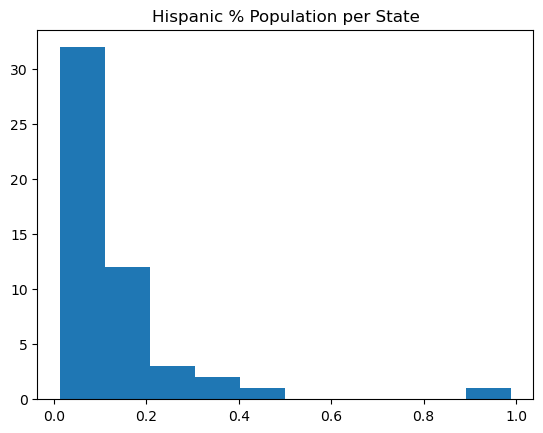

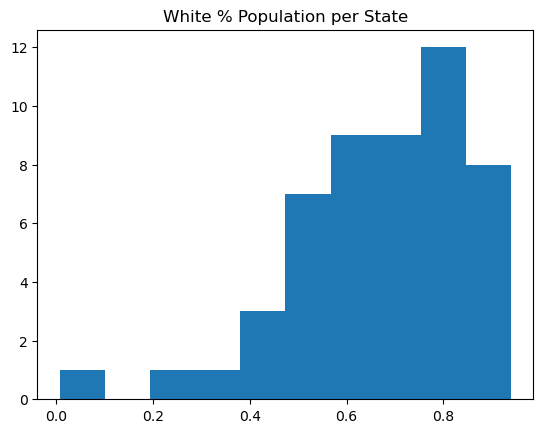

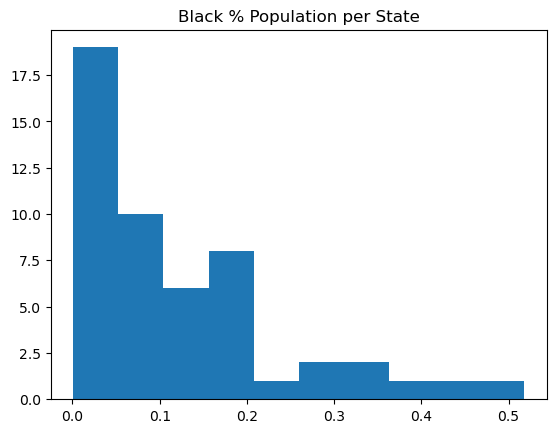

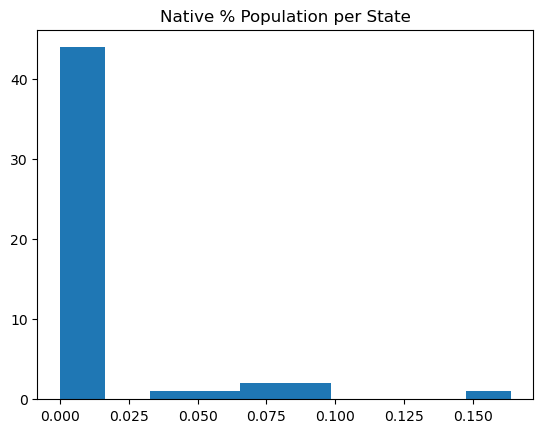

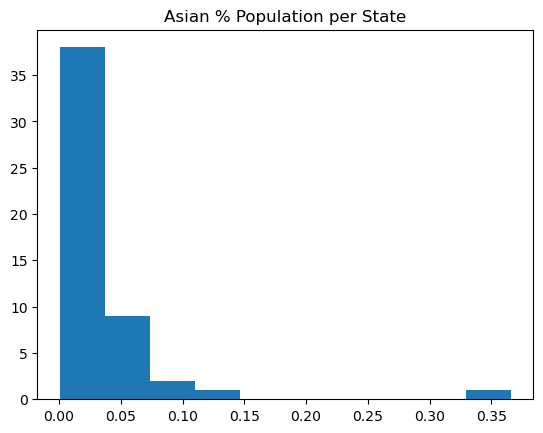

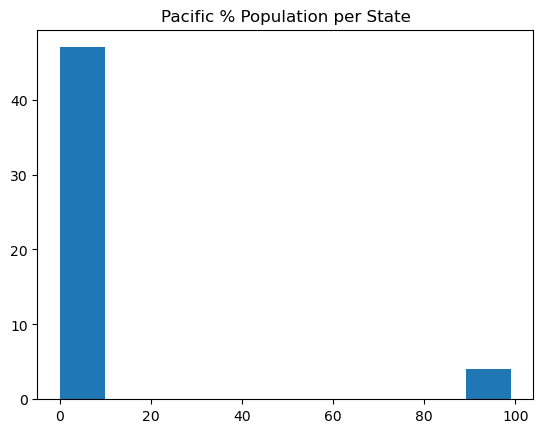

<Figure size 640x480 with 0 Axes>

In [21]:
for race in races:
    plt.hist(us_census[race], bins = 10)
    plt.title('{race} % Population per State'.format(race = race))
    plt.show()
    plt.clf()